# **CS412 - Recitation 6: Convolutional Neural Networks**

## **1. CNN Architecture**

CNNs are a special type of neural network designed to work with images, videos, and other grid-like data.
They learn spatial patterns (edges, textures, shapes, objects) by sliding small filters called **kernels** across the image.

![CNN Pipeline](https://www.mathworks.com/discovery/convolutional-neural-network/_jcr_content/mainParsys/band_copy_copy/mainParsys/lockedsubnav/mainParsys/columns/a32c7d5d-8012-4de1-bc76-8bd092f97db8/image_2109075398_cop.adapt.full.medium.jpg/1760340803666.jpg)

**Figure 1.** Typical CNN architecture: convolution → activation → pooling → fully connected.
**Source:** MathWorks (https://www.mathworks.com/discovery/convolutional-neural-network.html)

CNN models usually have two parts:

**1. Feature Extraction (left side)**
* Convolution layers learn filters to detect patterns
* ReLU introduces nonlinearity
* Pooling shrinks the feature maps for efficiency & invariance


![CNN Features](https://i.sstatic.net/T3a83.png)
**Figure 2.** Features in a CNN architecture
**Source:** DataScience (https://datascience.stackexchange.com/questions/77830/how-do-stacked-cnn-layers-work)

**2. Classification (right side)**
* Flatten converts features into a vector
* Fully connected layers make high-level decisions
* Softmax / sigmoid outputs final class probability

![Convolution GIF](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

**Figure 3.** 3×3 convolution sliding over an image.
Source: (https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

A convolution uses a small matrix (kernel, e.g., 3×3) and slides it across the image.
At each location:

* Multiply kernel values with pixel values
* Sum them
* Produce one output pixel

This operation detects edges, corners, or textures, depending on the kernel.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

###**Kernel Size, Stride, Padding**

#### **Kernel Size**

Determines how large a neighborhood you look at.

Larger → broader patterns.

Smaller → fine details.

#### **Stride**

How many pixels the kernel jumps each step.

Stride 1 → detailed

Stride 2 → faster but coarser

#### **Padding**

Adds borders so image size doesn’t shrink.

Same padding → output stays same size

Valid padding → output becomes smaller

<table>
  <tr>
    <td><img src="https://maucher.home.hdm-stuttgart.de/Pics/gif/no_padding_no_strides.gif" width="220"><br><center>Padding:0 Stride:1</center></td>
    <td><img src="https://maucher.home.hdm-stuttgart.de/Pics/gif/same_padding_no_strides.gif" width="220"><br><center>Padding:1 Stride:1</center></td>
    <td><img src="https://maucher.home.hdm-stuttgart.de/Pics/gif/no_padding_strides.gif" width="220"><br><center>Padding:0 Stride:2</center></td>
    <td><img src="https://maucher.home.hdm-stuttgart.de/Pics/gif/padding_strides.gif" width="220"><br><center>Padding:1 Stride:2</center></td>
  </tr>
</table>

**Figure 4.** 3×3 kernel with various padding and stride values

Source: (https://hannibunny.github.io/mlbook/neuralnetworks/convolutionDemos.html)


----------------------------------------------------------------------------------------------------------------------------------------------------------------

#### **Pooling**

Pooling reduces spatial size:

* makes computation cheaper

* gives location invariance

* prevents overfitting

Max pooling preserves the strongest signal in each area.

![Pooling](https://i.sstatic.net/6WbWu.png)

**Figure 5.** Typical CNN architecture: convolution → activation → pooling → fully connected.
**Source:** codegolf (https://codegolf.stackexchange.com/questions/195348/implement-the-max-pooling-operation-from-convolutional-neural-networks)

> **Recommended Video:**  
> Watching the following video by *3Blue1Brown* can help you build intuition for the convolution operation:  
> 👉 https://youtu.be/KuXjwB4LzSA


----------------------------------------------------------------------------------------------------------------------------------------------------------------

## **2. CelebA Dataset with VGG-16**

In this recitation, we will analyze how VGG-16 CNN can be applied on a subset of CelebA dataset to classify celebrity images based on gender.

In [ ]:
# Import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
full_data = pd.read_csv('/content/drive/CelebA30k.csv') # enter the file path on your drive for the csv file
full_data.head(5)


,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
full_data.columns


Index(['filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
full_data['Male'].value_counts()

,count
Male,
-1,17320
1,12680


In [ ]:
train = pd.read_csv('/content/drive/train_gender.csv')  # enter the file path on your drive for the csv file
test = pd.read_csv('/content/drive/test_gender.csv')    # enter the file path on your drive for the csv file


In [ ]:
# This will extract the contents of the zip file into a folder named data
# This part is not volatile.

!unzip "/content/drive/CelebA30k.zip" -d "/content/drive/data"

Archive:  /content/drive/My Drive/Colab Notebooks/CS412/Recit/CelebA Recit/CelebA30k.zip
replace /content/drive/My Drive/Colab Notebooks/CS412/Recit/CelebA Recit/data/CelebA30k/003301.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load the images to the VOLATILE memory.
!cp -r "/content/drive/data" /content/

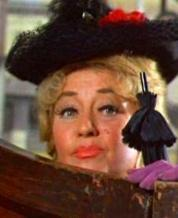

In [ ]:
first_image_path = os.path.join("/content/drive/CelebA30k/", train.loc[0,"filename"])
img = Image.open(first_image_path)
img

In [ ]:
# 1. Define basic transformations for training set
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),                                   # Resize from 224x224 to 128x128 to make the evaluation faster
    transforms.RandomHorizontalFlip(p=0.5),                          # Data augmentation: 50% chance of horizontal flip, introduces variety in poses
    transforms.ToTensor(),                                           # Convert image to tensor, the fundamental data structure of PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])  # Normalize using standard ImageNet values
])


In [ ]:
# 2. Create a custom Dataset class
class CelebADataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        # Map labels: -1 (Female) -> 0, 1 (Male) -> 1 for binary classification
        self.labels = [0 if label == -1 else 1 for label in dataframe['Male']]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path
        img_name = self.dataframe.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")


        # Get label
        label = self.labels[idx]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# 3. Create Dataset and DataLoader objects

img_dir = "/content/data/CelebA30k/"

# Create datasets
train_dataset = CelebADataset(
    dataframe=train,
    img_dir=img_dir,
    transform=train_transforms
)


# Create DataLoaders to feed data into the model in batches effectively.
batch_size = 64       # Different batch sizes can be experimented.
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,     # Shuffle for training so that model does not learn patterns
    num_workers=2,    # Multiple workers can be utilized for faster loading.
    pin_memory=True   # Optimize for GPU
)

# Verify DataLoader sizes
print(f'Training DataLoader: {len(train_loader)} batches of size {batch_size}')

Training DataLoader: 375 batches of size 64


In [ ]:
# Part 4: Transfer Learning with VGG-16

# Load pretrained VGG16
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze convolutional layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Print to see the overall structure:
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 113MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Observation

Let's pause and observe the VGG structure, you can refer to the image below to visualize the overall shape.

We'll need to adjust the structure (that is specifically constructed for ImageNet data) to fit our purposes.

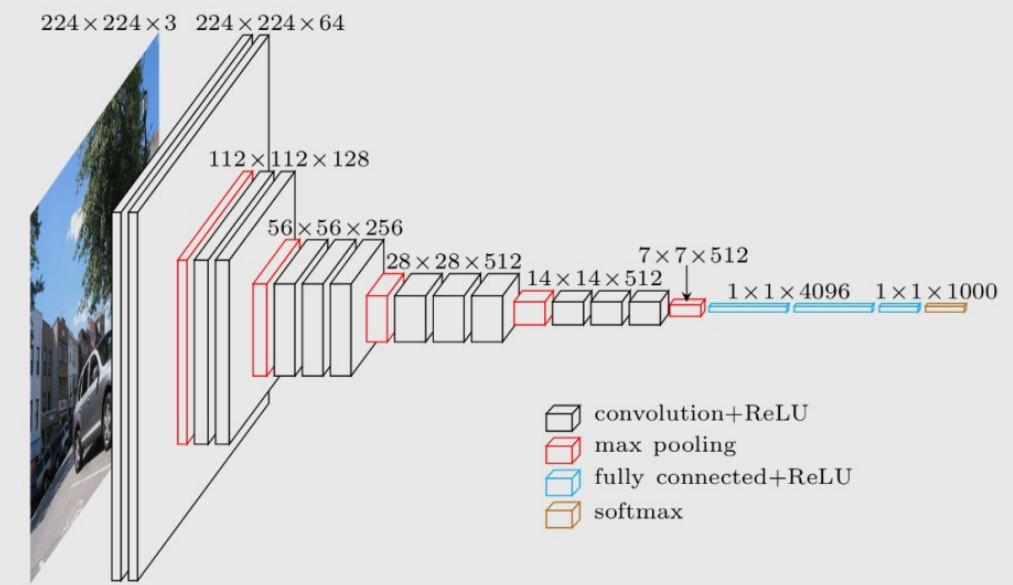

**Source:** Adapted from CS412 Course Slides by Berrin Yanıkoğlu


In [ ]:
# Replace only the final classification layer
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 1)   # Adjust for binary output (Male/Female)

# Move to GPU
vgg16 = vgg16.to(device)

# Print to see the overall structure:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Duration: 279.30907693100016


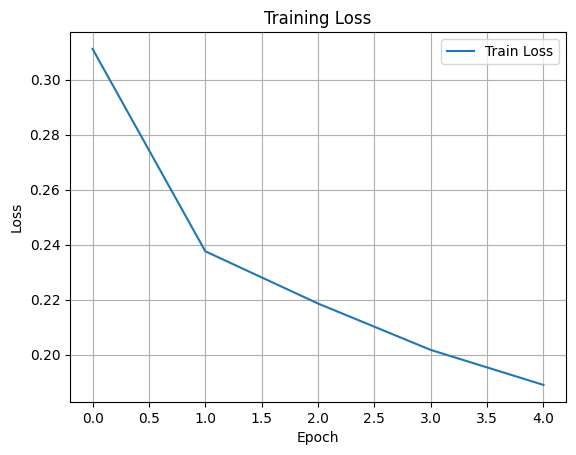

In [ ]:
# Part 5: Training

# Loss and Optimizer, with a single Learning Rate.
criterion = nn.BCEWithLogitsLoss()   # Binary Cross Entropy that expects logits as input (applies Sigmoid itself)
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)   # The optimizer is responsible for updating the model's weights using gradients.

# Training Loop
num_epochs = 5
train_losses = []

start = time.perf_counter()
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}")

    # Set the model into the training mode
    vgg16.train()  # Apply dropout, batch normalization etc.

    total_loss = 0
    for X, y in train_loader:
        X = X.to(device)           # Move the tensors to GPU memory
        y = y.to(device).float()   # BCEWithLogitsLoss expects float labels

        optimizer.zero_grad()     # Clear the old gradients to start the backwards pass anew
        logits = vgg16(X).squeeze()    # Remove the redundant dimension with .squeeze
        loss = criterion(logits, y)  # Compute loss
        loss.backward()        # Backpropagation
        optimizer.step()       # Update each weight

        total_loss += loss.item() * X.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
print(f"Duration: {time.perf_counter()-start}")

# Plot the loss curve
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


In [ ]:
# Part 6: Test and Evaluation

import random

# Create test dataset
test_dataset = CelebADataset(
    dataframe=test,
    img_dir=img_dir,
    transform=train_transforms
)

# Create test DataLoader, this time with a smaller batch and no shuffle
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

true_labels = []
pred_labels = []
image_tensors = []

vgg16.eval() # Set the model into evaluation mode
correct = 0
total = 0

with torch.no_grad():   # Do not track gradients for testing
    for X, y in test_loader:   # X=batch of images, y=labels
        X = X.to(device)
        y = y.to(device).float()

        logits = vgg16(X).squeeze()
        preds = (torch.sigmoid(logits) > 0.5).long()

        # accuracy stats
        correct += (preds.cpu() == y.cpu()).sum().item()   # Convert to cpu for comparison
        total += y.size(0)

        # store results for later visualization
        true_labels.extend(y.cpu().tolist())
        pred_labels.extend(preds.cpu().tolist())
        image_tensors.extend(X.cpu())


test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")



Test Accuracy: 0.9163



Displaying Correct Predictions:


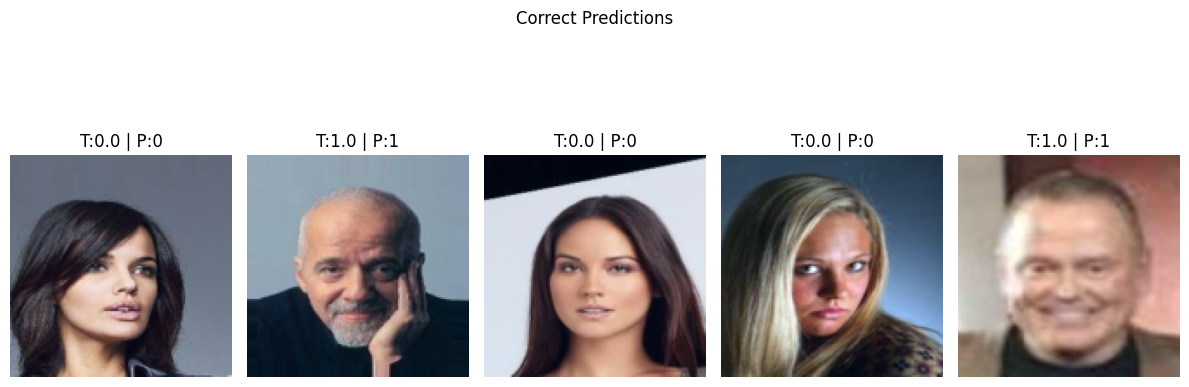


Displaying Incorrect Predictions:


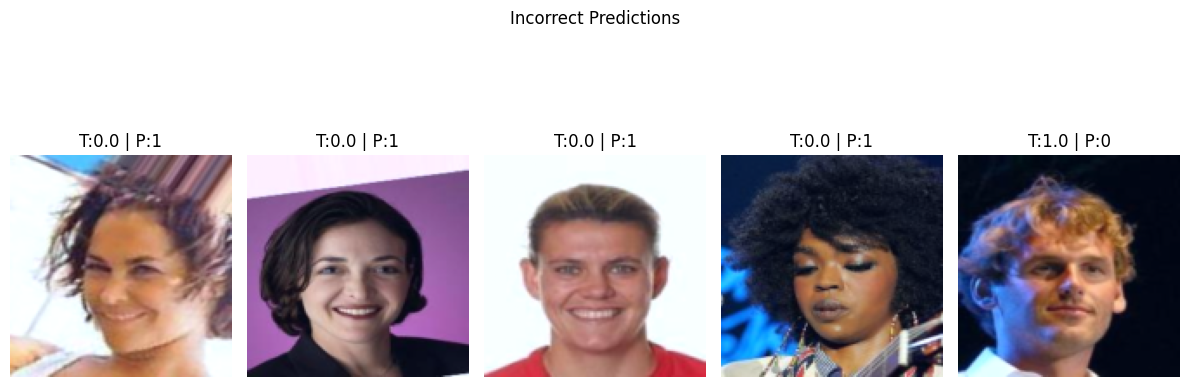

In [ ]:
def show_samples(indices, title):
    print(f"\nDisplaying {title}:")
    plt.figure(figsize=(12, 5))

    for i, idx in enumerate(indices):
        img_tensor = image_tensors[idx]   # Direct access
        label = true_labels[idx]
        pred = pred_labels[idx]

        # Undo normalization
        img = img_tensor.clone().numpy().transpose(1, 2, 0)
        img = np.clip((img * 0.229 + 0.485), 0, 1)

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"T:{label} | P:{pred}")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Identify correct and incorrect indices
correct_indices = [i for i in range(len(true_labels)) if true_labels[i] == pred_labels[i]]
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != pred_labels[i]]

sample_correct = random.sample(correct_indices, min(5, len(correct_indices)))
sample_incorrect = random.sample(incorrect_indices, min(5, len(incorrect_indices)))

# Display samples
show_samples(sample_correct, "Correct Predictions")
show_samples(sample_incorrect, "Incorrect Predictions")


## Final Comments

In this study, we've:

1. **Explored the CelebA Dataset**
   - Examined image structure and attribute labels
   - Loaded and visualized sample images

2. **Built Image Transformation Pipelines**
   - Applied resizing and normalization steps
   - Added basic augmentations
   - **Improvement:** Stronger augmentations (rotation, color jitter, blurring) and can be used to compare performance

3. **Constructed Data Generators / DataLoaders**
   - Efficiently loaded images in batches
   - Handled label extraction

4. **Performed Transfer Learning with VGG-16 (Frozen)**
   - Loaded pretrained VGG-16 weights
   - Froze all convolutional layers
   - Replaced the final classification layer to fit our labels

5. **Modified the Classifier Head**
   - Replaced the ImageNet 1000-class output layer with a binary output
   - Preserved the rest of the pretrained classifier

6. **Trained the Binary Classifier**
   - Used Binary Cross Entropy loss
   - Tracked training
   - **Possible Improvement:** We did not introduce validation set at all in this study, which is against the best practices.

7. **Evaluated Model Performance**
   - Reported overall test accuracy
   - Inspected sample predictions
   - Visualized Model Predictions
   
